In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Tuple

In [3]:
class Dataset2Classes(torch.utils.data.Dataset[Tuple[cv2.typing.MatLike, int]]):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        self.dir_list1 = sorted(os.listdir(path_dir1))
        self.dir_list2 = sorted(os.listdir(path_dir2))
        
    def __len__(self) -> int:
        return len(self.dir_list1) + len(self.dir_list2)
    
    def __getitem__(self, index:int) -> Tuple[cv2.typing.MatLike, int]:
        if (index < len(self.dir_list1)):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir_list1[index])
        else:
            class_id = 1
            img_path = os.path.join(self.path_dir2, self.dir_list2[index - len(self.dir_list1)])
            
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        img_typed: NDArray[np.float32] = img.astype(np.float32)
        img_typed = img_typed / 255.0
        img_typed = img_typed.transpose([2, 0, 1])

        t_img = torch.from_numpy(img_typed)
        t_class_id = torch.tensor([class_id], dtype=torch.long)
        
        return { 'img': t_img, 'label': t_class_id }

In [4]:
train_cats_path = './data/train/cats'
train_dogs_path = './data/train/dogs'
test_cats_path = './data/test/cats'
test_dogs_path = './data/test/dogs'

train_ds_catsdogs = Dataset2Classes(
    train_cats_path,
    train_dogs_path,
)
test_ds_catsdogs = Dataset2Classes(
    test_cats_path,
    test_dogs_path,
)

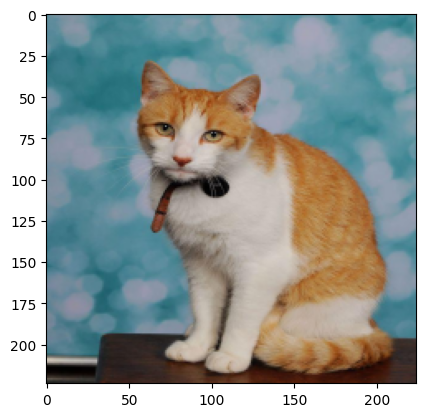

In [5]:
plt.imshow(test_ds_catsdogs[0]['img'].permute(1, 2, 0).numpy())

In [6]:
batch_size = 10

train_loader = torch.utils.data.DataLoader(
	train_ds_catsdogs,
 	batch_size=batch_size,
  	num_workers=1,
	shuffle=True,
	drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
	test_ds_catsdogs,
 	batch_size=batch_size,
  	num_workers=1,
	shuffle=True,
	drop_last=False,
)

In [7]:
class VGG16(nn.Module):
    def __init__(self, out_nc: int):
        super().__init__()
        
        self.act = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(7 * 7 * 512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 4096)
        self.fc4 = nn.Linear(4096, out_nc)
        
    def forward(self, x: torch.Tensor):
        out = self.conv1_1(x)
        out = self.act(out)
        out = self.conv1_2(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv2_1(out)
        out = self.act(out)
        out = self.conv2_2(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv3_1(out)
        out = self.act(out)
        out = self.conv3_2(out)
        out = self.act(out)
        out = self.conv3_3(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv4_1(out)
        out = self.act(out)
        out = self.conv4_2(out)
        out = self.act(out)
        out = self.conv4_3(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.conv5_1(out)
        out = self.act(out)
        out = self.conv5_2(out)
        out = self.act(out)
        out = self.conv5_3(out)
        out = self.act(out)
        
        out = self.maxpool(out)
        
        out = self.flat(out)
        
        out = self.fc1(out)
        out = self.act(out)
        
        out = self.fc2(out)
        out = self.act(out)
        
        out = self.fc3(out)
        out = self.act(out)

        out = self.fc4(out)
        
        return out

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def accuracy(pred, label):
    answer = ((F.sigmoid(pred.detach().cpu()).numpy() > 0.5) == (label.cpu().numpy() > 0.5))
    
    return answer.mean()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG16(1)
model.to(device)
count_parameters(model)

151045953

In [11]:
torch.cuda.is_available()

True

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 7

loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

for epoch in range(epochs):
    loss_value = 0
    acc_value = 0
    
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'].to(device), sample['label'].to(device).float()
        optimizer.zero_grad()
        
        pred = model(img)
        
        loss = loss_fn(pred, label)
        
        loss.backward()
        loss_item = loss.item()
        loss_value += loss_item
        
        optimizer.step()
        
        acc_current = accuracy(pred, label)
        acc_value += acc_current
        
        pbar.set_description(f'loss: {loss_item:.4e}\taccuracy: {acc_current:.4e}')
    
    print(loss_value / len(train_loader))
    print(acc_value / len(train_loader))

loss: 6.9172e-01	accuracy: 6.0000e-01: 100%|██████████| 55/55 [00:13<00:00,  4.23it/s]


0.8239287625659596
0.47818181818181826


loss: 6.9485e-01	accuracy: 4.0000e-01:  42%|████▏     | 23/55 [00:05<00:07,  4.38it/s]


KeyboardInterrupt: 

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG16(out_nc=2)
model.to(device)
model.eval()

img = cv2.imread('./uploads/dog_test.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (244, 244), interpolation=cv2.INTER_AREA)
img = img.astype(np.float32) / 255.0
img = np.transpose(img, (2, 0, 1))
img = np.expand_dims(img, axis=0)

test_img = torch.from_numpy(img).to(device)

with torch.no_grad():
    test_pred = model(test_img)
    predicted_class = torch.argmax(test_pred, dim=1).item()

In [17]:
print("Predicted class:", predicted_class)

Predicted class: 0
